In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [2]:

def create_data_model(waypoints):
    data = {}
    data['distance_matrix'] = compute_distance_matrix(waypoints)
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data

def compute_distance_matrix(waypoints):
    n = len(waypoints)
    distance_matrix = []
    for i in range(n):
        row = []
        for j in range(n):
            dx = waypoints[i][0] - waypoints[j][0]
            dy = waypoints[i][1] - waypoints[j][1]
            distance = int((dx**2 + dy**2)**0.5)
            row.append(distance)
        distance_matrix.append(row)
    return distance_matrix

def draw_circle(ax, center, radius):
    circle = plt.Circle(center, radius, color='b', fill=False)
    ax.add_artist(circle)
    
def print_solution(manager, routing, solution):
    print('TSP Distance: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    return plan_output



In [3]:
def angle_between_points(p1, p2):
    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])
import numpy as np

def angle_between_points(p1, p2):
    return np.arctan2(p2[1] - p1[1], p2[0] - p1[0])

def point_on_circle(center, angle, radius):
    x = center[0] + radius * np.cos(angle)
    y = center[1] + radius * np.sin(angle)
    return (x, y)

In [4]:
def plot_solution(waypoints, plan_output, radius):
    ordered_points = [waypoints[int(node)] for node in plan_output.split() if node.isdigit()]
    ordered_points.append(ordered_points[0])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(*zip(*ordered_points))

    for i, point in enumerate(ordered_points[:-1]):
        plt.annotate(i, (point[0] + 0.5, point[1] + 0.5))
        if i > 0 and i < len(ordered_points) - 2:  # Exclude start and end points from circles
            draw_circle(ax, point, radius)

    new_path = [ordered_points[0]]
    for i in range(1, len(ordered_points) - 2):
        # calculate angle and chords for the current waypoint
        angle = angle_between_points(ordered_points[i-1], ordered_points[i])
        nextangle = angle_between_points(ordered_points[i], ordered_points[i+1])
        chord_start = point_on_circle(ordered_points[i], angle - np.pi , radius)
        chord_end = point_on_circle(ordered_points[i], nextangle , radius)

        # calculate the chord for the previous waypoint
        prev_angle = angle_between_points(ordered_points[i - 2] if i > 1 else ordered_points[0], ordered_points[i-1])
        prev_chord_end = point_on_circle(ordered_points[i-1], prev_angle + np.pi / 2, radius)

        # add the point on the current waypoint's circle that is closest to the previous waypoint
        if np.linalg.norm(np.array(chord_start) - np.array(prev_chord_end)) < np.linalg.norm(np.array(chord_end) - np.array(prev_chord_end)):
            new_path.extend([chord_start, chord_end])
            ax.plot(*zip(*[chord_start, chord_end]), 'r-')  # visualize the chord
        else:
            new_path.extend([chord_end, chord_start])
            ax.plot(*zip(*[chord_end, chord_start]), 'r-')  # visualize the chord

    # add the ending point
    new_path.append(ordered_points[-1])
    total_distance = sum(np.linalg.norm(np.array(new_path[i]) - np.array(new_path[i+1])) for i in range(len(new_path) - 1))
    print(f"Total distance of new path: {total_distance:.2f}")
    ax.plot(*zip(*new_path), linestyle='-', marker='o')
    

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Solution')
    plt.grid()
    plt.axis('equal')
    plt.show()
    return total_distance

TSP Distance: 87 miles
Route for vehicle 0:
 0 -> 3 -> 1 -> 2 -> 0

Total distance of new path: 81.22


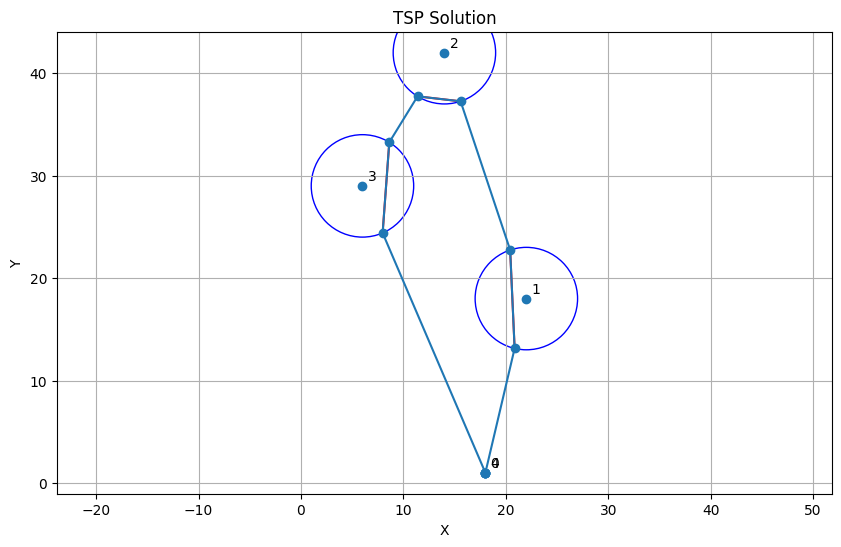

In [5]:
def main(waypoints):
    data = create_data_model(waypoints)
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        plan_output = print_solution(manager, routing, solution)
        plot_solution(waypoints, plan_output, radius)
        return plan_output
    return None
if __name__ == '__main__':
    waypoints = [(random.randint(0, 50), random.randint(0, 50)) for _ in range(4)]
    #waypoints = [(20,10),(10,10),(30,10)]
    radius = 5
    plan_output = main(waypoints)


In [7]:
waypoints

[(20, 10), (10, 10), (30, 10)]

In [6]:
import numpy as np
import random

class Node:
    def __init__(self, waypoints, parent=None, radius=None):
        self.waypoints = waypoints
        self.children = []
        self.wins = 0
        self.visits = 0
        self.parent = parent
        self.radius = radius

    def selection(self):
        selected_node = self
        while len(selected_node.children) > 0:
            selected_node = max(selected_node.children, key = lambda c: c.wins/c.visits + np.sqrt(2*np.log(selected_node.visits)/c.visits))
        return selected_node

    def expansion(self, radii):
        for radius in radii:
            self.children.append(Node(self.waypoints[1:], self, radius))

    def simulation(self):
        random_radius_sequence = [random.choice(radii) for _ in range(len(self.waypoints))]
        # This is where you would use the TSP solver to get the total distance for the sequence.
        total_distance = (waypoints, plan_output, radius)
        return total_distance

    def backpropagation(self, result):
        self.visits += 1
        self.wins += result
        if self.parent:
            self.parent.backpropagation(result)


waypoints = [(20,10),(10,10),(30,10)]
radii = [2, 3, 5]

root = Node(waypoints)

for _ in range(1000): # Number of simulations.
    selected_node = root.selection()
    if len(selected_node.waypoints) > 0:
        selected_node.expansion(radii)
        selected_node = random.choice(selected_node.children)
    result = selected_node.simulation()
    selected_node.backpropagation(result)


TypeError: unsupported operand type(s) for +=: 'int' and 'tuple'